# 평가기준
1. Transformer와 비교해 변경이 필요한 부분을 서술
  - 제출 노트북 파일 앞부분에 텍스트 블럭으로 서술
  - 코드 블럭에 변경사항을 주석으로 표시
2. 모델의 입력 형태에 맞게 전처리 수행
  - Decoder 기반의 생성모델임을 감안, 챗봇 데이터를 변형
3. 모델의 입력 블럭을 GPT 논문에 기반하여 수정
4. GPT 모델을 정상적으로 구성(model.summary, model.fit 결과 캡쳐 첨부)
5. 입력에 따른 출력 생성

# 주요 변경사항

* Transformer 구조의 Decoder만 사용
* 데이터셋은 Question + Answer, Unlabeled Dataset
* inputs에는 START TOKEN, END TOKEN, outputs에는 END TOKEN 추가
* Positional Encoding 대신 Postion Embedding 구현
* Encoder-Decoder Multi-Head Attention 파트 제거

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from tensorflow.keras.utils import plot_model

In [2]:
data_path = 'transformer_chatbot/data/ChatbotData.csv'
data = pd.read_csv(data_path)

# 데이터 전처리

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 특수 문자 앞뒤로 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 연속된 공백을 하나의 공백으로 치환
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (한글, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r'[^가-힣].,?!', ' ', sentence)
    sentence = sentence.strip()
    return sentence

In [4]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations(questions, answers):
    inputs, outputs = [], []
    
    for q, a in zip(questions, answers):
        inputs.append(preprocess_sentence(q))
        outputs.append(preprocess_sentence(a))
    
    return inputs, outputs

In [5]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations(data['Q'], data['A'])
print('전체 샘플 수 :', len(questions))

전체 샘플 수 : 11823


In [6]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [7]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [8]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [9]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


In [10]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이 -> Questions, Answers의 최대 단어 개수인 29+2로 설정
# 2 for Start Token, End Token
MAX_LENGTH = 31
print(MAX_LENGTH)

31


In [11]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        # input에는 START TOKEN, END TOKEN, output에는 END TOKEN 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 31 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
        else:
            print(sentence2, len(sentence2))

    # 최대 길이 31로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [12]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions+answers
    },
    {
        'outputs': questions[:,1:]+answers[:,1:]
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 모델 구성

In [14]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)  # (batch_size, seq_len, d_model)
    key = self.key_dense(key)  # (batch_size, seq_len, d_model)
    value = self.value_dense(value)  # (batch_size, seq_len, d_model)

    # Split heads
    query = self.split_heads(query, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    key = self.split_heads(key, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    value = self.split_heads(value, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [16]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [17]:
# 디코더 하나의 레이어를 함수로 구현.
# Masked Multi Self Attention - Add - Layer Norm - Feed Forward - Add - Layer Norm

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 멀티 헤드 셀프 어텐션 수행
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
    })

    # 인코더-디코더 어텐션 파트 제거
    
    # LayerNormalization
    attention1 = tf.keras.layers.Add()([inputs, attention1])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1)
    attention1 = tf.keras.layers.Dropout(rate=dropout)(attention1)

    # Feed Forward Networks : 2개의 완전연결층
    ffn = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
    ffn = tf.keras.layers.Dense(units=d_model)(ffn)

    # LayerNormalization
    outputs = tf.keras.layers.Add()([attention1, ffn])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)

    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask],
        outputs=outputs,
        name=name)

In [18]:
class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [19]:
def decoder(vocab_size, num_layers, units, maxlen, d_model, num_heads, dropout, name='decoder'):
    
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 임베딩 레이어
    embedding_layer = PositionEmbedding(maxlen, vocab_size, d_model)
    outputs = embedding_layer(inputs)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i+1),
    )(inputs=[outputs, look_ahead_mask])
    
    
    # decoder layers 12개를 시각화 하기 위한 코드
    decoder_layers = tf.keras.Model(inputs=[inputs, look_ahead_mask],
        outputs=outputs,
        name=name)
    decoder_layers.summary()
    plot_model(decoder_layers, to_file='decoder_layers.png')
    
    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask],
        outputs=outputs,
        name=name)

In [20]:
# 하이퍼파라미터
NUM_LAYERS = 12 # 디코더 층의 개수
D_MODEL = 256 # 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

In [21]:
def gpt(vocab_size, num_layers, units, maxlen, d_model, num_heads, dropout, name="GPT"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(inputs)
    
    outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        maxlen=maxlen,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        )(inputs=[inputs, look_ahead_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [22]:
model = gpt(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    maxlen=MAX_LENGTH,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
position_embedding (PositionEmb (None, None, 256)    2100736     inputs[0][0]                     
__________________________________________________________________________________________________
look_ahead_mask (InputLayer)    [(None, 1, None, Non 0                                            
__________________________________________________________________________________________________
decoder_layer_1 (Functional)    (None, None, 256)    527104      position_embedding[0][0]         
                                                                 look_ahead_mask[0][0]      

In [23]:
# 전체 모델 시각화
model.summary()

Model: "GPT"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    8425984     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 8175)   2100975     decoder[0][0]                  

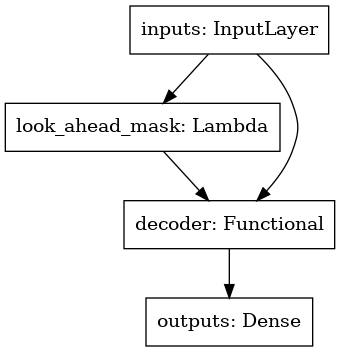

In [24]:
plot_model(model, to_file='gpt_model.png' )

In [25]:
def loss_function(y_true, y_pred):
    y_pred = y_pred[:, :tf.shape(y_true)[1], :]

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [26]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

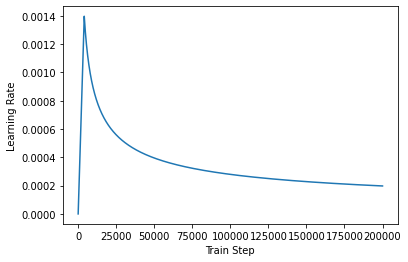

In [27]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [28]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_pred = y_pred[:, :tf.shape(y_true)[1], :]
    y_true = tf.reshape(y_true, shape=(-1, tf.shape(y_pred)[1]))

    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [29]:
EPOCHS = 10
hist = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 29s 84ms/step - loss: nan - accuracy: 0.7329
Epoch 2/10
185/185 [==============================] - 16s 84ms/step - loss: nan - accuracy: 0.7370
Epoch 3/10
185/185 [==============================] - 16s 85ms/step - loss: nan - accuracy: 0.7370
Epoch 4/10
185/185 [==============================] - 16s 84ms/step - loss: nan - accuracy: 0.7370
Epoch 5/10
185/185 [==============================] - 16s 84ms/step - loss: nan - accuracy: 0.7370
Epoch 6/10
185/185 [==============================] - 16s 84ms/step - loss: nan - accuracy: 0.7370
Epoch 7/10
185/185 [==============================] - 16s 84ms/step - loss: nan - accuracy: 0.7370
Epoch 8/10
185/185 [==============================] - 16s 86ms/step - loss: nan - accuracy: 0.7370
Epoch 9/10
185/185 [==============================] - 16s 84ms/step - loss: nan - accuracy: 0.7370
Epoch 10/10
185/185 [==============================] - 16s 84ms/step - loss: nan - accuracy: 0.7370


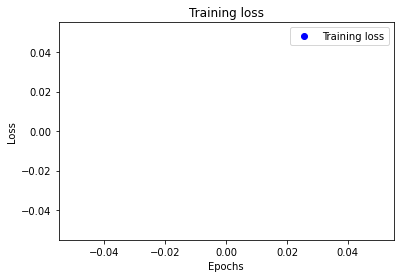

In [30]:
loss = hist.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [31]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    sentence = tf.reshape(sentence, [-1])
    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in sentence:
    # 디코더는 입력 문장의 한 단어씩 받아 다음 단어 예측을 반복합니다.
        i = tf.reshape(i, (1,1))
        predictions = model(inputs=i, training=False)
        
        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [32]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])
    
    # 특수 문자 앞 공백 제거
    predicted_sentence = re.sub(r" ([?.!,])", r"\1", predicted_sentence)
    
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [33]:
sentence_generation('오늘 날씨 어때?')

입력 : 오늘 날씨 어때?
출력 : 


''